In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import yaml
import random
from pathlib import Path

# Set up paths
dataset_path = "/home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset"
train_images_path = os.path.join(dataset_path, "images/train")
train_labels_path = os.path.join(dataset_path, "labels/train")
dataset_yaml_path = os.path.join(dataset_path, "dataset.yaml")

# Load dataset configuration
with open(dataset_yaml_path, 'r') as f:
    dataset_config = yaml.safe_load(f)

class_names = dataset_config['names']
print(f"Dataset classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Dataset classes: {0: 'wood_block', 1: 'cracker_box', 2: 'juice', 3: 'mug', 4: 'cola_can', 5: 'tissue', 6: 'master_chef_can'}
Number of classes: 7


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def yolo_to_bbox(yolo_coords, img_width, img_height):
    """
    Convert YOLO format coordinates to bounding box coordinates
    YOLO format: [class_id, x_center, y_center, width, height] (normalized)
    Returns: [x_min, y_min, x_max, y_max] (absolute coordinates)
    """
    class_id, x_center, y_center, width, height = yolo_coords
    
    # Convert normalized coordinates to absolute coordinates
    x_center_abs = x_center * img_width
    y_center_abs = y_center * img_height
    width_abs = width * img_width
    height_abs = height * img_height
    
    # Calculate bounding box corners
    x_min = int(x_center_abs - width_abs / 2)
    y_min = int(y_center_abs - height_abs / 2)
    x_max = int(x_center_abs + width_abs / 2)
    y_max = int(y_center_abs + height_abs / 2)
    
    return [x_min, y_min, x_max, y_max], int(class_id)

def load_annotations(label_file):
    """Load YOLO format annotations from a text file"""
    annotations = []
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    annotations.append([class_id, x_center, y_center, width, height])
    return annotations

def visualize_sample(image_path, label_path, class_names, ax=None):
    """Visualize a single training sample with bounding boxes"""
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    # Load annotations
    annotations = load_annotations(label_path)
    
    # Create plot if axis not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Display image
    ax.imshow(image)
    ax.set_title(f"Training Sample: {os.path.basename(image_path)}")
    
    # Define colors for different classes
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'brown', 'gray']
    
    # Draw bounding boxes
    for annotation in annotations:
        bbox, class_id = yolo_to_bbox(annotation, img_width, img_height)
        x_min, y_min, x_max, y_max = bbox
        
        # Get class name and color
        class_name = class_names.get(class_id, f'class_{class_id}')
        color = colors[class_id % len(colors)]
        
        # Draw rectangle
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                        linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        ax.text(x_min, y_min - 5, f'{class_name} ({class_id})', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                fontsize=8, color='white', weight='bold')
    
    ax.axis('off')
    
    # Print annotation info
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Image size: {img_width}x{img_height}")
    print(f"Number of objects: {len(annotations)}")
    for i, annotation in enumerate(annotations):
        class_id = int(annotation[0])
        class_name = class_names.get(class_id, f'class_{class_id}')
        print(f"  Object {i+1}: {class_name} (class_id: {class_id})")

def visualize_training_samples(num_samples=6):
    """Visualize multiple training samples in a grid"""
    # Get list of training images
    image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    
    # Randomly select samples
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Create subplot grid
    cols = 3
    rows = (len(selected_files) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, image_file in enumerate(selected_files):
        row = i // cols
        col = i % cols
        
        image_path = os.path.join(train_images_path, image_file)
        label_path = os.path.join(train_labels_path, image_file.replace('.jpg', '.txt'))
        
        ax = axes[row, col] if rows > 1 else axes[col]
        visualize_sample(image_path, label_path, class_names, ax)
        print("-" * 50)
    
    # Hide empty subplots
    for i in range(len(selected_files), rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to analyze dataset statistics
def analyze_dataset():
    """Analyze the dataset and show statistics"""
    print("=" * 60)
    print("DATASET ANALYSIS")
    print("=" * 60)
    
    # Count images and labels
    train_images = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    train_labels = [f for f in os.listdir(train_labels_path) if f.endswith('.txt')]
    val_images = [f for f in os.listdir(os.path.join(dataset_path, "images/val")) if f.endswith('.jpg')]
    val_labels = [f for f in os.listdir(os.path.join(dataset_path, "labels/val")) if f.endswith('.txt')]
    
    print(f"Training images: {len(train_images)}")
    print(f"Training labels: {len(train_labels)}")
    print(f"Validation images: {len(val_images)}")
    print(f"Validation labels: {len(val_labels)}")
    
    # Count objects per class
    class_counts = {class_id: 0 for class_id in class_names.keys()}
    total_objects = 0
    
    for label_file in train_labels:
        label_path = os.path.join(train_labels_path, label_file)
        annotations = load_annotations(label_path)
        total_objects += len(annotations)
        
        for annotation in annotations:
            class_id = int(annotation[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
    
    print(f"\nTotal training objects: {total_objects}")
    print("\nClass distribution:")
    for class_id, count in class_counts.items():
        class_name = class_names[class_id]
        percentage = (count / total_objects) * 100 if total_objects > 0 else 0
        print(f"  {class_name} (ID: {class_id}): {count} objects ({percentage:.1f}%)")
    
    return class_counts

In [4]:
# Run dataset analysis
analyze_dataset()

DATASET ANALYSIS
Training images: 84
Training labels: 84
Validation images: 22
Validation labels: 22

Total training objects: 1117

Class distribution:
  wood_block (ID: 0): 181 objects (16.2%)
  cracker_box (ID: 1): 146 objects (13.1%)
  juice (ID: 2): 192 objects (17.2%)
  mug (ID: 3): 152 objects (13.6%)
  cola_can (ID: 4): 159 objects (14.2%)
  tissue (ID: 5): 152 objects (13.6%)
  master_chef_can (ID: 6): 135 objects (12.1%)


{0: 181, 1: 146, 2: 192, 3: 152, 4: 159, 5: 152, 6: 135}


TRAINING SAMPLES VISUALIZATION
Image: 0057.jpg
Image size: 1280x720
Number of objects: 17
  Object 1: cracker_box (class_id: 1)
  Object 2: cracker_box (class_id: 1)
  Object 3: master_chef_can (class_id: 6)
  Object 4: master_chef_can (class_id: 6)
  Object 5: master_chef_can (class_id: 6)
  Object 6: mug (class_id: 3)
  Object 7: juice (class_id: 2)
  Object 8: cola_can (class_id: 4)
  Object 9: tissue (class_id: 5)
  Object 10: mug (class_id: 3)
  Object 11: juice (class_id: 2)
  Object 12: wood_block (class_id: 0)
  Object 13: wood_block (class_id: 0)
  Object 14: tissue (class_id: 5)
  Object 15: cola_can (class_id: 4)
  Object 16: juice (class_id: 2)
  Object 17: wood_block (class_id: 0)
--------------------------------------------------
Image: 0007.jpg
Image size: 1280x720
Number of objects: 9
  Object 1: cracker_box (class_id: 1)
  Object 2: cola_can (class_id: 4)
  Object 3: wood_block (class_id: 0)
  Object 4: mug (class_id: 3)
  Object 5: mug (class_id: 3)
  Object 6: wood_

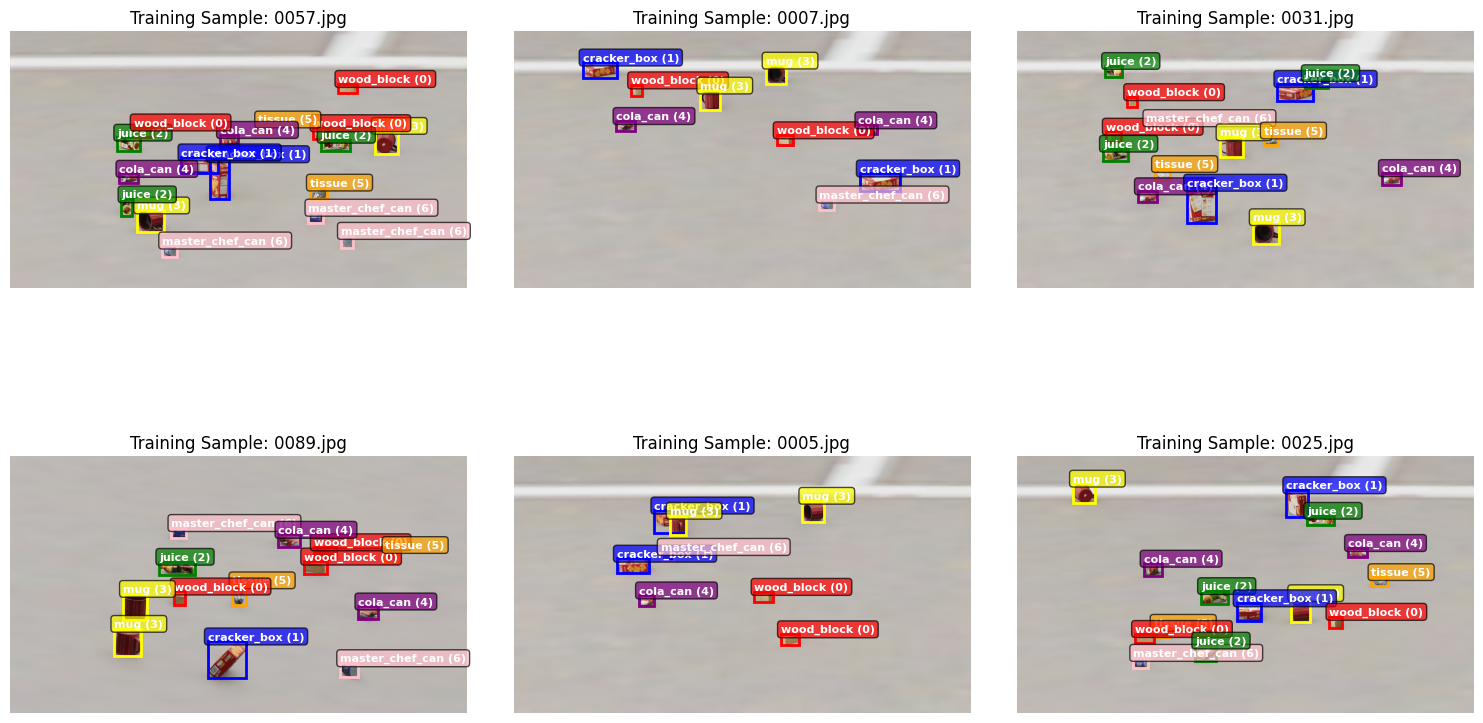

In [5]:
# Visualize 6 random training samples with bounding boxes
print("\n" + "=" * 60)
print("TRAINING SAMPLES VISUALIZATION")
print("=" * 60)
visualize_training_samples(num_samples=6)


DETAILED SINGLE SAMPLE VISUALIZATION
Image: 0001.jpg
Image size: 1280x720
Number of objects: 17
  Object 1: cracker_box (class_id: 1)
  Object 2: juice (class_id: 2)
  Object 3: cola_can (class_id: 4)
  Object 4: tissue (class_id: 5)
  Object 5: wood_block (class_id: 0)
  Object 6: wood_block (class_id: 0)
  Object 7: tissue (class_id: 5)
  Object 8: master_chef_can (class_id: 6)
  Object 9: juice (class_id: 2)
  Object 10: juice (class_id: 2)
  Object 11: master_chef_can (class_id: 6)
  Object 12: master_chef_can (class_id: 6)
  Object 13: cola_can (class_id: 4)
  Object 14: cola_can (class_id: 4)
  Object 15: wood_block (class_id: 0)
  Object 16: mug (class_id: 3)
  Object 17: tissue (class_id: 5)


<Figure size 1200x800 with 0 Axes>

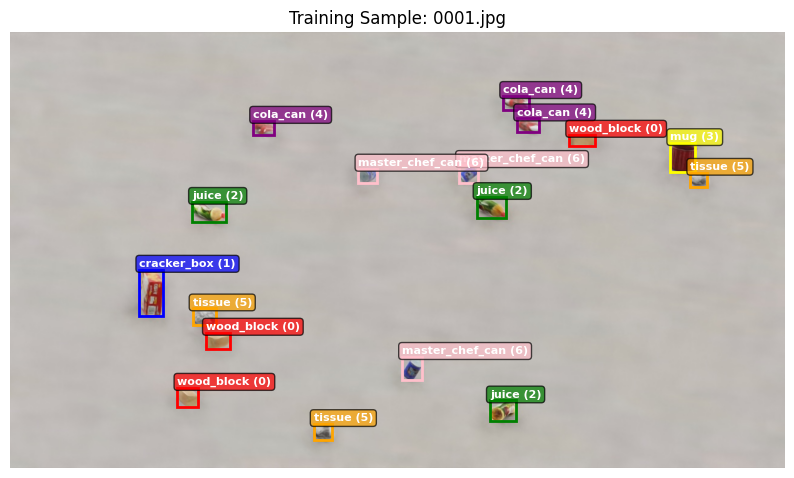

In [6]:
# Visualize a specific training sample in detail
print("\n" + "=" * 60)
print("DETAILED SINGLE SAMPLE VISUALIZATION")
print("=" * 60)

# Choose a specific image for detailed view
sample_image = "0001.jpg"
sample_image_path = os.path.join(train_images_path, sample_image)
sample_label_path = os.path.join(train_labels_path, sample_image.replace('.jpg', '.txt'))

if os.path.exists(sample_image_path) and os.path.exists(sample_label_path):
    plt.figure(figsize=(12, 8))
    visualize_sample(sample_image_path, sample_label_path, class_names)
    plt.show()
else:
    print(f"Sample image {sample_image} not found. Using first available image.")
    # Use first available image
    available_images = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    if available_images:
        sample_image = available_images[0]
        sample_image_path = os.path.join(train_images_path, sample_image)
        sample_label_path = os.path.join(train_labels_path, sample_image.replace('.jpg', '.txt'))
        plt.figure(figsize=(12, 8))
        visualize_sample(sample_image_path, sample_label_path, class_names)
        plt.show()


CLASS DISTRIBUTION VISUALIZATION


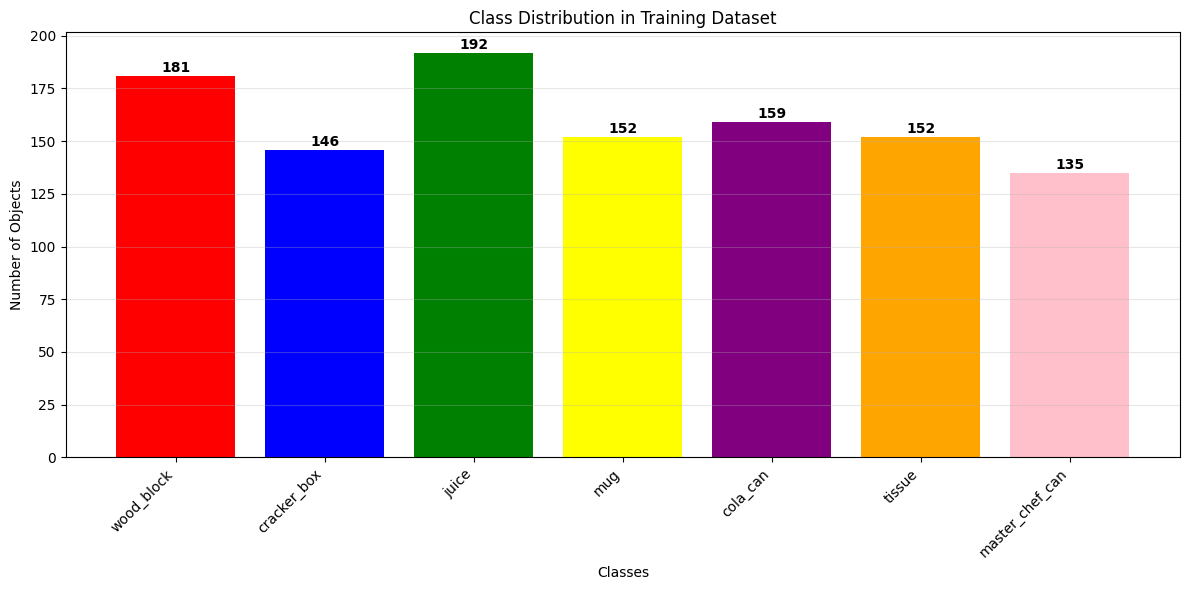

In [7]:
# Visualize class distribution
def plot_class_distribution():
    """Plot class distribution as bar chart"""
    # Count objects per class
    class_counts = {class_id: 0 for class_id in class_names.keys()}
    
    for label_file in os.listdir(train_labels_path):
        if label_file.endswith('.txt'):
            label_path = os.path.join(train_labels_path, label_file)
            annotations = load_annotations(label_path)
            
            for annotation in annotations:
                class_id = int(annotation[0])
                if class_id in class_counts:
                    class_counts[class_id] += 1
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    class_ids = list(class_counts.keys())
    counts = list(class_counts.values())
    class_labels = [class_names[cid] for cid in class_ids]
    
    bars = ax.bar(class_labels, counts, color=['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink'])
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Objects')
    ax.set_title('Class Distribution in Training Dataset')
    ax.grid(axis='y', alpha=0.3)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return class_counts

print("\n" + "=" * 60)
print("CLASS DISTRIBUTION VISUALIZATION")
print("=" * 60)
class_distribution = plot_class_distribution()

In [9]:
import torch

torch.cuda.is_available()

True

In [10]:
# Import YOLO for fine-tuning
from ultralytics import YOLO
import time

print("=" * 60)
print("YOLO MODEL FINE-TUNING")
print("=" * 60)

# Step 1: Load pre-trained model
print("📦 Loading pre-trained YOLO model...")
model_path = "/home/kwdahun/metasejong-airobotics/sources/yolo11n.pt"
model = YOLO(model_path)
print(f"✓ Model loaded from: {model_path}")

# Step 2: Verify dataset configuration
print(f"📊 Dataset configuration:")
print(f"  - Dataset path: {dataset_yaml_path}")
print(f"  - Number of classes: {len(class_names)}")
print(f"  - Classes: {list(class_names.values())}")

# Step 3: Start fine-tuning
print("\n🚀 Starting fine-tuning process...")
start_time = time.time()

try:
    results = model.train(
        data=dataset_yaml_path,  # Use the dataset.yaml path from our setup
        epochs=50,               # Training epochs
        imgsz=640,              # Image size
        batch=8,                # Batch size
        lr0=0.001,              # Initial learning rate
        weight_decay=0.0005,    # Weight decay for regularization
        warmup_epochs=3,        # Warmup epochs
        patience=15,            # Early stopping patience
        save_period=10,         # Save checkpoint every 10 epochs
        name="metasejong_objects",  # Project name
        exist_ok=True,          # Overwrite existing project
        pretrained=True,        # Use pretrained weights
        optimizer='AdamW',      # Optimizer
        cos_lr=True,            # Cosine learning rate scheduler
        freeze=10,              # Freeze first 10 layers initially
        verbose=True,           # Verbose output
        plots=True,             # Generate training plots
        val=True,               # Validate during training
        save=True,              # Save final model
        cache=False,            # Don't cache images (saves memory)
        device='cuda',          # Auto-select device (GPU if available)
    )
    
    training_time = time.time() - start_time
    print(f"\n✅ Training completed successfully!")
    print(f"⏱️  Total training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
    
    # Display training results
    print(f"\n📈 Training Results:")
    print(f"  - Best mAP50: {results.results_dict.get('metrics/mAP50(B)', 'N/A')}")
    print(f"  - Best mAP50-95: {results.results_dict.get('metrics/mAP50-95(B)', 'N/A')}")
    print(f"  - Final loss: {results.results_dict.get('train/box_loss', 'N/A')}")
    
    # Model save location
    print(f"\n💾 Model saved to: {results.save_dir}")
    print(f"  - Best weights: {results.save_dir}/weights/best.pt")
    print(f"  - Last weights: {results.save_dir}/weights/last.pt")
    
except Exception as e:
    print(f"❌ Training failed with error: {str(e)}")
    print("Please check your dataset configuration and try again.")

YOLO MODEL FINE-TUNING
📦 Loading pre-trained YOLO model...
✓ Model loaded from: /home/kwdahun/metasejong-airobotics/sources/yolo11n.pt
📊 Dataset configuration:
  - Dataset path: /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/dataset.yaml
  - Number of classes: 7
  - Classes: ['wood_block', 'cracker_box', 'juice', 'mug', 'cola_can', 'tissue', 'master_chef_can']

🚀 Starting fine-tuning process...
New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
Ultralytics 8.3.159 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf

train: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/train... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 2263.39it/s]

train: New cache created: /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1999.7±1536.6 MB/s, size: 82.1 KB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1999.7±1536.6 MB/s, size: 82.1 KB)


val: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/val... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 2087.76it/s]

val: New cache created: /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/val.cache


Plotting labels to runs/detect/metasejong_objects/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/metasejong_objects
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/metasejong_objects
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.816G      1.049      3.793     0.8661         97        640: 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         22        278    0.00192      0.165     0.0339     0.0248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50     0.832G     0.7993      2.932     0.8225         62        640: 100%|██████████| 11/11 [00:01<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.80it/s]

                   all         22        278   0.000801      0.143     0.0796     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.844G     0.7686      2.348      0.821        113        640: 100%|██████████| 11/11 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         22        278   0.000801      0.143     0.0702     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.854G      0.767       2.02     0.8264         97        640: 100%|██████████| 11/11 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         22        278      0.254      0.185      0.195       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.926G     0.7703      1.781     0.8292        128        640: 100%|██████████| 11/11 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]

                   all         22        278        0.3      0.424       0.34       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.93G     0.7391      1.599     0.8249         84        640: 100%|██████████| 11/11 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         22        278      0.221      0.685      0.451       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.945G     0.7307      1.485     0.8377         87        640: 100%|██████████| 11/11 [00:01<00:00,  8.05it/s]
       7/50     0.945G     0.7307      1.485     0.8377         87        640: 100%|██████████| 11/11 [00:01<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         22        278      0.242      0.881      0.685      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.957G     0.7032      1.354     0.8313         96        640: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s]
       8/50     0.957G     0.7032      1.354     0.8313         96        640: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         22        278      0.176      0.967      0.758      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.967G     0.7033      1.302     0.8279         45        640: 100%|██████████| 11/11 [00:01<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]

                   all         22        278      0.941      0.418      0.881      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.979G     0.7019      1.212     0.8307        101        640: 100%|██████████| 11/11 [00:01<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         22        278      0.971      0.501       0.91      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.988G     0.6937      1.144     0.8268        125        640: 100%|██████████| 11/11 [00:01<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]

                   all         22        278      0.955      0.731       0.93      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.996G     0.6636      1.107     0.8246         66        640: 100%|██████████| 11/11 [00:01<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

                   all         22        278      0.924      0.873      0.948      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.01G     0.6386      1.046     0.8181         73        640: 100%|██████████| 11/11 [00:01<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         22        278      0.933      0.874      0.955      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.02G     0.6329      1.028      0.821         74        640: 100%|██████████| 11/11 [00:01<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]

                   all         22        278      0.928      0.879       0.96      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.03G     0.6554     0.9829     0.8159        145        640: 100%|██████████| 11/11 [00:01<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]

                   all         22        278      0.947      0.894      0.964      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.04G     0.6284     0.9647     0.8143         50        640: 100%|██████████| 11/11 [00:01<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         22        278      0.946      0.912      0.968      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.05G     0.6398      0.926     0.8182         97        640: 100%|██████████| 11/11 [00:01<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         22        278      0.949      0.927      0.969      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.06G     0.6164     0.9472     0.8134         81        640: 100%|██████████| 11/11 [00:01<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         22        278      0.955      0.943      0.972      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.07G      0.605     0.8877     0.8072         85        640: 100%|██████████| 11/11 [00:01<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]

                   all         22        278      0.964      0.942      0.972      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.14G     0.6095     0.8549     0.8185         75        640: 100%|██████████| 11/11 [00:01<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         22        278      0.966      0.938      0.973      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.16G     0.5902     0.8229     0.8034         70        640: 100%|██████████| 11/11 [00:01<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         22        278      0.967      0.942      0.974       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.17G     0.6605     0.8808      0.815         98        640: 100%|██████████| 11/11 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         22        278      0.967      0.946      0.974      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.18G     0.5888      0.808     0.8132        140        640: 100%|██████████| 11/11 [00:01<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

                   all         22        278      0.973      0.946      0.975      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.19G     0.5607     0.7699     0.8118         65        640: 100%|██████████| 11/11 [00:01<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

                   all         22        278      0.951      0.964      0.974      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       1.2G     0.6169     0.7933     0.8106        113        640: 100%|██████████| 11/11 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         22        278      0.952      0.963      0.976      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.21G     0.5717     0.7691     0.8058         83        640: 100%|██████████| 11/11 [00:01<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

                   all         22        278       0.96      0.955      0.976      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.22G     0.5911     0.7574     0.8031         80        640: 100%|██████████| 11/11 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]

                   all         22        278      0.964      0.952      0.976      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.23G     0.5813     0.7433     0.8059        111        640: 100%|██████████| 11/11 [00:01<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         22        278      0.974       0.95      0.976      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.24G     0.5523     0.7137     0.8064         94        640: 100%|██████████| 11/11 [00:01<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

                   all         22        278      0.975       0.95      0.976      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.25G     0.5751      0.751     0.8065         85        640: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         22        278      0.976      0.952      0.976      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.26G     0.5664     0.7027     0.8148         78        640: 100%|██████████| 11/11 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         22        278       0.98       0.95      0.976      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.27G     0.5767     0.7077     0.8015        134        640: 100%|██████████| 11/11 [00:01<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         22        278      0.981       0.95      0.976      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.28G     0.5629     0.7032     0.8065        155        640: 100%|██████████| 11/11 [00:01<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

                   all         22        278      0.971      0.962      0.976      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.29G     0.5834     0.6956     0.8137         75        640: 100%|██████████| 11/11 [00:01<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]

                   all         22        278      0.971      0.963      0.976      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       1.3G     0.5741     0.7157     0.8079        111        640: 100%|██████████| 11/11 [00:01<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]

                   all         22        278      0.971      0.963      0.976      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.31G     0.5758     0.6968     0.8084        126        640: 100%|██████████| 11/11 [00:01<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

                   all         22        278      0.974      0.968      0.976      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.33G     0.5398     0.6704     0.8048         66        640: 100%|██████████| 11/11 [00:01<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         22        278      0.974      0.968      0.976      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.34G     0.5328     0.6866     0.8062         92        640: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]

                   all         22        278      0.974      0.968      0.976      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.35G     0.5339     0.6842     0.8051         66        640: 100%|██████████| 11/11 [00:01<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]

                   all         22        278      0.975      0.968      0.976      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.36G     0.5367     0.6767     0.8048         73        640: 100%|██████████| 11/11 [00:01<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         22        278      0.975      0.968      0.976      0.889


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.37G     0.4923     0.7447     0.7917         54        640: 100%|██████████| 11/11 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         22        278      0.974      0.969      0.977      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.38G     0.4867     0.7194     0.7923         47        640: 100%|██████████| 11/11 [00:01<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

                   all         22        278      0.973      0.969      0.977      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.39G     0.4727     0.6994      0.792         58        640: 100%|██████████| 11/11 [00:01<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.74it/s]

                   all         22        278      0.973      0.969      0.977      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.39G     0.5061      0.734     0.7965         51        640: 100%|██████████| 11/11 [00:01<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         22        278      0.969      0.973      0.977      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.41G     0.5119     0.7658     0.7927         47        640: 100%|██████████| 11/11 [00:01<00:00,  9.38it/s]
      45/50      1.41G     0.5119     0.7658     0.7927         47        640: 100%|██████████| 11/11 [00:01<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 20.52it/s]

                   all         22        278      0.972      0.971      0.977       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.42G      0.488     0.6916      0.795         58        640: 100%|██████████| 11/11 [00:00<00:00, 11.37it/s]
      46/50      1.42G      0.488     0.6916      0.795         58        640: 100%|██████████| 11/11 [00:00<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.07it/s]

                   all         22        278      0.971      0.972      0.977       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.43G     0.4753     0.6942     0.7889         60        640: 100%|██████████| 11/11 [00:01<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]

                   all         22        278       0.97      0.974      0.977      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.44G     0.4826     0.6885     0.7936         54        640: 100%|██████████| 11/11 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.12it/s]


                   all         22        278       0.97      0.974      0.977      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.45G     0.4815     0.6811     0.7955         58        640: 100%|██████████| 11/11 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.08it/s]

                   all         22        278       0.97      0.974      0.977      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.46G     0.4724     0.6667     0.7974         53        640: 100%|██████████| 11/11 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.96it/s]

                   all         22        278       0.97      0.974      0.977      0.887



50 epochs completed in 0.026 hours.
Optimizer stripped from runs/detect/metasejong_objects/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/metasejong_objects/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/metasejong_objects/weights/best.pt, 5.4MB

Validating runs/detect/metasejong_objects/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
Optimizer stripped from runs/detect/metasejong_objects/weights/best.pt, 5.4MB

Validating runs/detect/metasejong_objects/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 21.43it/s]



                   all         22        278      0.975      0.968      0.976      0.892
            wood_block         22         46      0.978      0.969      0.975      0.879
           cracker_box         22         37      0.954          1      0.977       0.93
                 juice         20         43      0.986          1      0.995      0.905
                   mug         21         43      0.982      0.977      0.979      0.951
              cola_can         21         41      0.952          1      0.972      0.879
                tissue         19         38      0.974      0.868      0.944      0.843
       master_chef_can         20         30          1      0.965      0.992      0.857
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/metasejong_objects
            wood_block         22         46      0.978      0.969      0.975      0.879
           cracker_box         22         37      0.954          1   

In [11]:
# Model Evaluation and Validation
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Load the best trained model for evaluation
try:
    # Path to the best model weights (update this path based on your training results)
    best_model_path = "runs/detect/metasejong_objects/weights/best.pt"
    
    if os.path.exists(best_model_path):
        print(f"📊 Loading best model from: {best_model_path}")
        trained_model = YOLO(best_model_path)
        
        # Validate the model on validation set
        print("\n🔍 Validating model on validation set...")
        val_results = trained_model.val(
            data=dataset_yaml_path,
            imgsz=640,
            batch=8,
            conf=0.25,
            iou=0.5,
            plots=True,
            save_json=True,
            name="validation_results"
        )
        
        # Display validation metrics
        print(f"\n📈 Validation Results:")
        print(f"  - mAP50: {val_results.box.map50:.4f}")
        print(f"  - mAP50-95: {val_results.box.map:.4f}")
        print(f"  - Precision: {val_results.box.mp:.4f}")
        print(f"  - Recall: {val_results.box.mr:.4f}")
        
        # Per-class metrics
        print(f"\n📊 Per-class metrics:")
        for i, class_name in enumerate(class_names.values()):
            if i < len(val_results.box.ap50):
                ap50 = val_results.box.ap50[i]
                print(f"  - {class_name}: mAP50 = {ap50:.4f}")
        
        print(f"\n✅ Model evaluation completed!")
        
    else:
        print(f"❌ Best model not found at: {best_model_path}")
        print("Please make sure training has completed successfully.")
        
except Exception as e:
    print(f"❌ Evaluation failed with error: {str(e)}")
    print("Training might still be in progress or failed.")

MODEL EVALUATION
📊 Loading best model from: runs/detect/metasejong_objects/weights/best.pt

🔍 Validating model on validation set...
Ultralytics 8.3.159 🚀 Python-3.10.12 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11885MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2035.0±741.2 MB/s, size: 77.6 KB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2035.0±741.2 MB/s, size: 77.6 KB)


val: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]
val: Scanning /home/kwdahun/metasejong-airobotics/data/labelme_yolo_dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]



                   all         22        278      0.975      0.968      0.975      0.909
            wood_block         22         46      0.978      0.969      0.969      0.887
           cracker_box         22         37      0.954          1      0.977       0.95
                 juice         20         43      0.986          1      0.995      0.923
                   mug         21         43      0.982      0.977      0.988      0.973
              cola_can         21         41      0.951          1      0.972      0.889
                tissue         19         38      0.974      0.868      0.945      0.866
       master_chef_can         20         30          1      0.965      0.982      0.877
Speed: 0.9ms preprocess, 30.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Saving runs/detect/validation_results/predictions.json...
            wood_block         22         46      0.978      0.969      0.969      0.887
           cracker_box         22         37      0.954   

TESTING TRAINED MODEL
🧪 Testing trained model...
🧪 Testing model on 4 sample images...
  ✓ 0069.jpg: 13 objects detected
  ✓ 0003.jpg: 9 objects detected
  ✓ 0016.jpg: 11 objects detected
  ✓ 0067.jpg: 12 objects detected


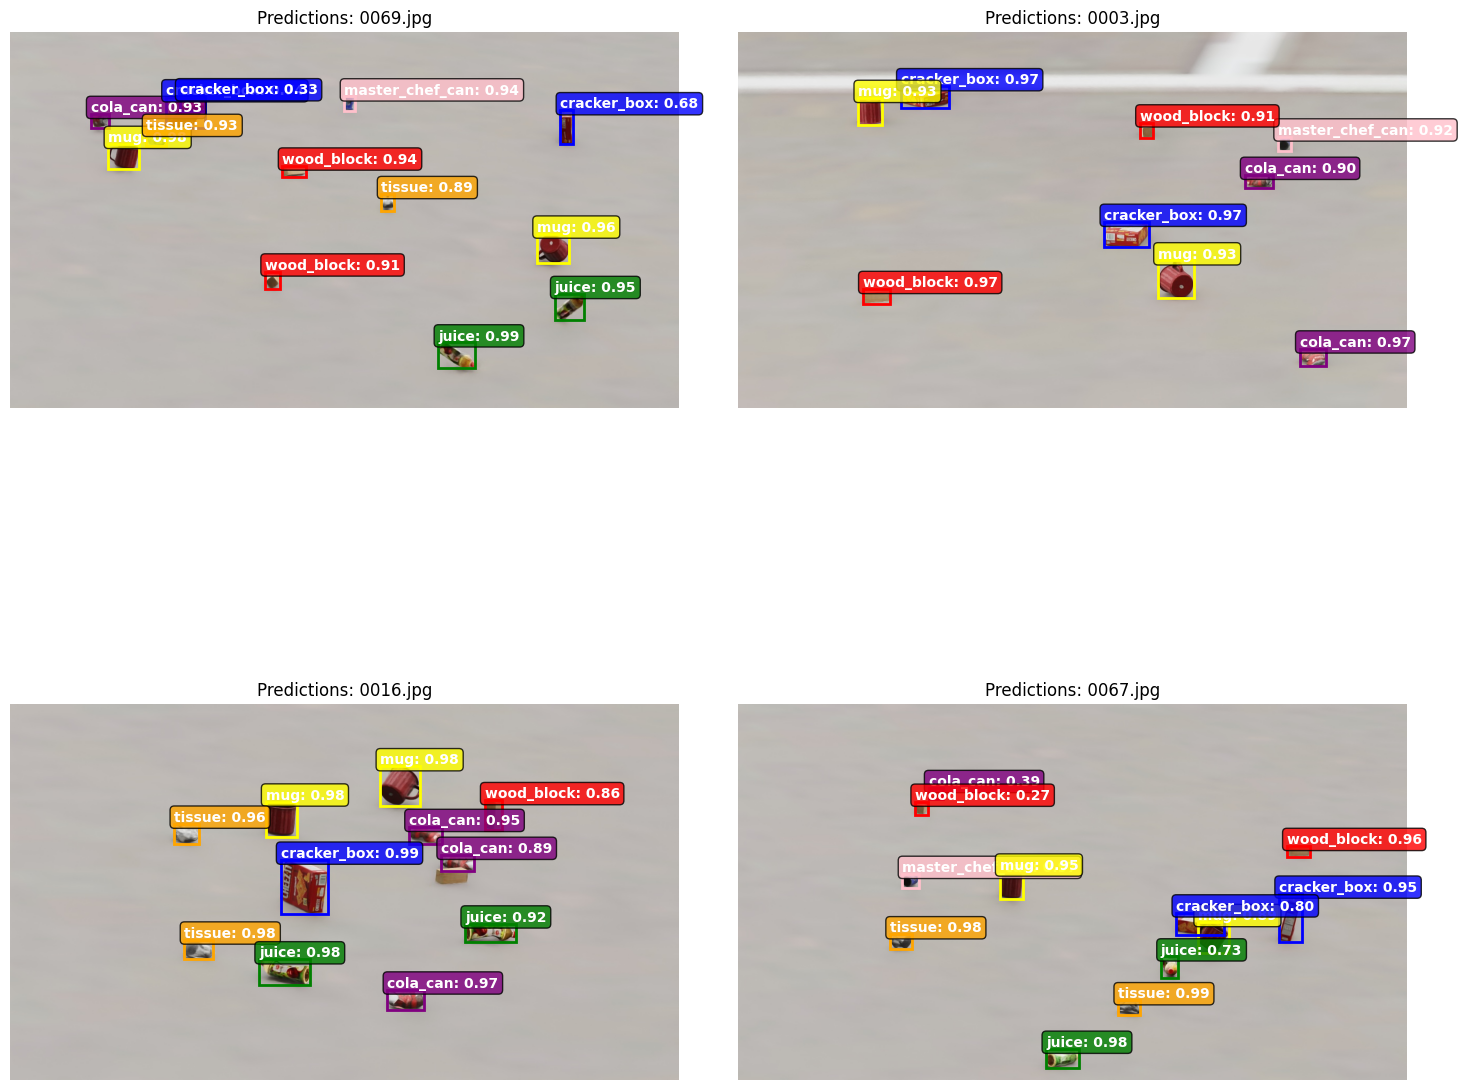

✅ Testing completed on 4 images!


In [3]:
from ultralytics import YOLO

# Test the trained model on sample images
print("=" * 60)
print("TESTING TRAINED MODEL")
print("=" * 60)

def test_trained_model(model_path, test_images_path, num_samples=4):
    """Test the trained model on sample images"""
    try:
        # Load the trained model
        trained_model = YOLO(model_path)
        
        # Get test images
        test_images = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]
        selected_images = random.sample(test_images, min(num_samples, len(test_images)))
        
        # Create subplot grid
        cols = 2
        rows = (len(selected_images) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 8 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        print(f"🧪 Testing model on {len(selected_images)} sample images...")
        
        for i, image_file in enumerate(selected_images):
            image_path = os.path.join(test_images_path, image_file)
            
            # Run inference
            results = trained_model.predict(
                image_path,
                conf=0.25,
                iou=0.5,
                save=False,
                verbose=False
            )
            
            # Load original image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Plot results
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Display image
            ax.imshow(image)
            ax.set_title(f"Predictions: {image_file}", fontsize=12)
            
            # Draw predictions
            if len(results[0].boxes) > 0:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confidences = results[0].boxes.conf.cpu().numpy()
                class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
                
                colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan']
                
                for box, conf, cls_id in zip(boxes, confidences, class_ids):
                    x1, y1, x2, y2 = box
                    color = colors[cls_id % len(colors)]
                    
                    # Draw bounding box
                    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)
                    
                    # Add label
                    class_name = class_names.get(cls_id, f'class_{cls_id}')
                    label = f'{class_name}: {conf:.2f}'
                    ax.text(x1, y1 - 5, label,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                           fontsize=10, color='white', weight='bold')
                
                print(f"  ✓ {image_file}: {len(boxes)} objects detected")
            else:
                print(f"  ⚠️ {image_file}: No objects detected")
                ax.text(0.5, 0.5, 'No objects detected', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.7))
            
            ax.axis('off')
        
        # Hide empty subplots
        for i in range(len(selected_images), rows * cols):
            row = i // cols
            col = i % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Testing completed on {len(selected_images)} images!")
        
    except Exception as e:
        print(f"❌ Testing failed with error: {str(e)}")

# Test the model if it exists
best_model_path = "runs/detect/metasejong_objects/weights/best.pt"
if os.path.exists(best_model_path):
    print(f"🧪 Testing trained model...")
    # Test on validation images
    val_images_path = os.path.join(dataset_path, "images/val")
    test_trained_model(best_model_path, val_images_path, num_samples=4)
else:
    print(f"⚠️ Trained model not found at: {best_model_path}")
    print("Please run the training cell first to create the model.")